In [2]:
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl

mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize= 12)
mpl.rc('ytick', labelsize = 12)

Tensors and Operations 

In [3]:
#matrix
tf.constant([[1.,2.,3.], [4.,5.,6]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
#scalar
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
t = tf.constant([[1.,2.,3.], [4.,5.,6]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

Indexing

In [6]:
t[:,1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

Ops

In [8]:
t +10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

The @ operator was added in Python 3.5, for matrix multiplication: it is equivalent to calling the tf.matmul() function:

In [10]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

From/To Numpy 

In [11]:
a = np.array([2.,4.,5.,])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [12]:
t.numpy()

#from tf to np

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [13]:
np.array(t)

#from np to tf

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
tf.square(a)

#from tf to np

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [15]:
np.square(t)


#from np to tf

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

Customizing Models and Training Algorithms 

Custom Loss Functions 

Load and prep the california housing dataset: load, split into a training set, a val set, and a test set, then scale it

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [17]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1,1))

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)



In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

 create a function that takes the labels and predictions as arguments, and use
TensorFlow operations to compute every instance’s loss

In [19]:
def huber_fn(y_true, y_pred):
    error =y_true - y_pred
    is_small_error =  tf.abs(error)<1
    squared_loss = tf.square(error)/2
    linear_loss = tf.abs(error)-0.5
    return tf.where(is_small_error,squared_loss,linear_loss)

Huber loss is not currently part of the official Keras API, but it is available in tf.keras (just use an instance of the keras.losses.Huber class)

<function matplotlib.pyplot.show(close=None, block=None)>

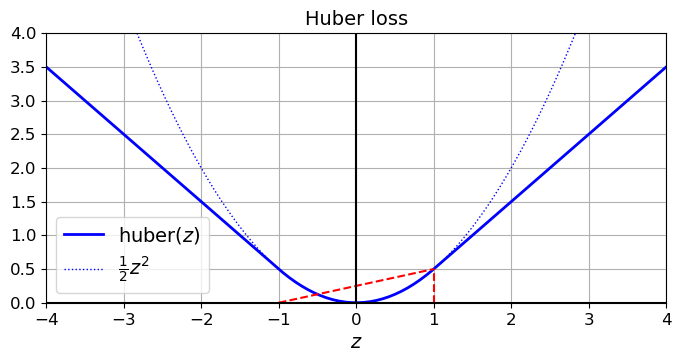

In [20]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (8, 3.5))
z = np.linspace(-4,4,200)
plt.plot(z, huber_fn(0,z), 'b-',linewidth=2, label= "huber($z$)")
plt.plot(z, z**2/2, "b:", linewidth=1, label = r"$\frac{1}{2}z^2$")
plt.plot([-1,1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1,1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color="k")
plt.gca().axvline(x=0, color="k")
plt.axis([-4,4,0,4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show



In [21]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer= "lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(loss= huber_fn, optimizer = "nadam", metrics = ["mae"])

In [23]:
model.fit(X_train_scaled, y_train,epochs=2, validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0808 - mae: 1.4924 - val_loss: 0.3462 - val_mae: 0.6356
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2189 - mae: 0.5155 - val_loss: 0.2854 - val_mae: 0.5701


Saving/Loading Models with Custom Objects

In [24]:
model.save("my_model_custom_loss.keras")

In [25]:
model = keras.models.load_model("my_model_custom_loss.keras", custom_objects = {"huber_fn": huber_fn})

In [26]:
model.fit(X_train_scaled, y_train, epochs = 2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2118 - mae: 0.5042 - val_loss: 0.2395 - val_mae: 0.5212
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2064 - mae: 0.4963 - val_loss: 0.1961 - val_mae: 0.4758


Any error between -1 and 1 is considered “small”, but what if we want a different threshold? One solution is to create a function that creates a configured loss function:

In [27]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true-y_pred
        is_small_error = tf.abs(error)<threshold
        squared_loss = tf.square(error)/2
        linear_loss = threshold * tf.abs(error)-threshold**2/2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn 



In [28]:
model.compile(loss=create_huber(2.0), optimizer = "nadam", metrics=["mae"])

In [29]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2276 - mae: 0.4939 - val_loss: 0.2105 - val_mae: 0.4650
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2234 - mae: 0.4888 - val_loss: 0.1962 - val_mae: 0.4558


In [30]:
model.save("my_model_custom_loss.keras")

when you save the model, the threshold will not be saved. This means that you will have to specify the threshold value when loading the model

In [31]:
model = keras.models.load_model ("my_model_custom_loss.keras", custom_objects={"huber_fn":create_huber(2.0)})

In [32]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2189 - mae: 0.4839 - val_loss: 0.1979 - val_mae: 0.4550
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2157 - mae: 0.4798 - val_loss: 0.2053 - val_mae: 0.4570


Solve this by creating a subclass of the keras.losses.Loss class, and implement its get_config() method:

In [33]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold 
        super().__init__(**kwargs) 
    def call(self, y_true,y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <self.threshold
        squared_loss =tf.square(error)
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2/2
        return tf.where(is_small_error,squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "selu", kernel_initializer="lecun_normal",
    input_shape=input_shape),
])

In [35]:
model.compile(loss=HuberLoss(2.), optimizer = "nadam", metrics=["mae"])

In [36]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8853 - mae: 2.0864 - val_loss: 2.3117 - val_mae: 1.7136
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1732 - mae: 1.6405 - val_loss: 1.6605 - val_mae: 1.3163


In [37]:
model.save("model_custom_class.keras")

In [38]:
model = keras.models.load_model("model_custom_class.keras", custom_objects = {"HuberLoss": HuberLoss})

In [39]:
model.fit(X_train_scaled, y_train, epochs = 2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5722 - mae: 1.2692 - val_loss: 1.1532 - val_mae: 0.9928
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1045 - mae: 0.9654 - val_loss: 0.8006 - val_mae: 0.7583


Other Custom Functions

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)



In [42]:
layer = keras.layers.Dense(1, activation = my_softplus,
                            kernel_initializer = my_glorot_initializer,
                            kernel_regularizer=my_l1_regularizer,
                            kernel_constraint = my_positive_weights)

In [43]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

If a function has some hyperparameters that need to be saved along with the model,
then just subclass the appropriate class, such as keras.regularizers.Regularizer,                 keras.constraints.Constraint, keras.initializers.Initializer or keras.layers.Layer (for any layer, including activation functions)

In [44]:
from keras.regularizers import Regularizer

class MyL1Regularizer(Regularizer):
    def __init__(self, l1=0.01):
        self.l1 = l1

    def __call__(self, x):
        return self.l1 * K.sum(K.abs(x))

# Create an instance of your custom regularizer
my_l1_regularizer= MyL1Regularizer(l1=0.01)


In [45]:
from keras.constraints import Constraint

class my_positive_weights(Constraint):
    def __call__(self, weights):
        return K.relu(weights)

my_positive_weights = my_positive_weights()

In [46]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])


Custom Metrics

In [47]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer ="lecun_normal",
    input_shape = input_shape),
    keras.layers.Dense(1),

])

In [49]:
model.compile(loss= "mse", optimizer = "nadam", metrics = [create_huber(2.0)])

In [50]:
model.fit(X_train_scaled, y_train, epochs =2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - huber_fn: 1.3559 - loss: 3.0876
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - huber_fn: 0.2631 - loss: 0.5375


NOTE-:


    1. The loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).

    
    2. The metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing. 

Streaming Metrics

In [51]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [52]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

Notice, after the first batch, it returns the precision of 80%, then after the second batch it returns 50% (which is the overall precision so far, not the second batch’s precision). This is called a streaming metric (orstateful metric), as it is gradually updated, batch after batch

At any point, we can call the result() method to get the current value of the metric.
We can also look at its variables (tracking the number of true and false positives)
using the variables attribute, and reset these variables using the reset_states() method

In [53]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [54]:
precision.variables

[<KerasVariable shape=(1,), dtype=float32, path=precision/true_positives>,
 <KerasVariable shape=(1,), dtype=float32, path=precision/false_positives>]

In [55]:
#precision.reset_states() is deprecated 

Creating a strreaming metric

In [56]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}




• The constructor uses the add_weight() method to create the variables needed to
keep track of the metric’s state over multiple batches, in this case the sum of all
Huber losses (total) and the number of instances seen so far (count). You could
just create variables manually if you preferred. Keras tracks any tf.Variable that
is set as an attribute (and more generally, any “trackable” object, such as layers or
models).


• The update_state() method is called when you use an instance of this class as a
function (as we did with the Precision object). It updates the variables given the
labels and predictions for one batch (and sample weights, but in this case we just
ignore them).


• The result() method computes and returns the final result, in this case just the
mean Huber metric over all instances. When you use the metric as a function, the
update_state() method gets called first, then the result() method is called,
and its output is returned.


• We also implement the get_config() method to ensure the threshold gets
saved along with the model.

• The default implementation of the reset_states() method just resets all vari‐
ables to 0.0 (but you can override it if needed)

In [57]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self,threshold, name = 'huber_metric', dtype=tf.float32):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


This class handles shape better and supports sample weights 

In [58]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "selu", kernel_initializer = "lecun_normal", input_shape = input_shape),
    keras.layers.Dense(1),
])

In [59]:
model.compile(loss = keras.losses.Huber(2.0), optimizer = "nadam", weighted_metrics = [HuberMetric(2.0)])

In [60]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2, sample_weight= sample_weight)

Epoch 1/2


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - huber_metric: 1.6699 - loss: 0.8311
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric: 0.2629 - loss: 0.1307


In [61]:
history.history["loss"][0], history.history["huber_metric"][0] * sample_weight.mean()

(0.44582274556159973, 0.44582282034206727)

Custom Layers

If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a keras.layers.Lambda layer.

In [62]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [63]:
input = tf.constant([-1.0, 0.0, 1.0], dtype = tf.float32)

In [64]:
exponential_layer(input)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

 exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales (e.g., 0.001, 10., 1000.).

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape = input_shape),
    keras.layers.Dense(1),
    exponential_layer
  
 ])

model.compile(loss= "mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6677 - val_loss: 0.4546
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4934 - val_loss: 0.3889
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4355 - val_loss: 0.3702
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4185 - val_loss: 0.3590
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4153 - val_loss: 0.3529
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3654


0.3708721101284027

In [66]:
import tensorflow as tf
from tensorflow import keras

class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", 
            shape=(batch_input_shape[-1], self.units), 
            initializer="glorot_normal",
            dtype=tf.float32
        )
        self.bias = self.add_weight(
            name="bias", 
            shape=(self.units,), 
            initializer="zeros", 
            dtype=tf.float32
        )
        super(MyDense, self).build(batch_input_shape)
    
    def call(self, inputs):
        z = tf.matmul(inputs, self.kernel) + self.bias
        return self.activation(z)


In [67]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

C:\Users\user\AppData\Local\Temp\ipykernel_20772\3691450218.py:6: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyDense, self).__init__(**kwargs)


In [68]:
input_shape = (8,)  # Adjusted input shape to match the data

# Define the model with the correct input shape
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),  # Specify adjusted input shape
    MyDense(30, activation='relu'),
    MyDense(1)
])

# Compile the model
model.compile(optimizer="nadam", loss="mse")

# Train the model
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

# Evaluate the model
model.evaluate(X_test_scaled, y_test)

Epoch 1/2


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8616 - val_loss: 1.4324
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7134 - val_loss: 0.5722
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.5247


0.5197387933731079

In [69]:
model.save("model_with_custom_layer.keras")

To create a layer with multiple inputs (e.g., Concatenate), the argument to the call() method should be a tuple containing all the inputs, and similarly the argument to the compute_output_shape() method should be a tuple containing each input’s batch shape. To create a layer with multiple outputs, the call() method should return the list of outputs, and the compute_output_shape() should return the list of batch output shapes (one per output).

Multilayer 

In [70]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape, "X2.shape: ",X2.shape) #debugging custom layer 
        return X1 + X2, X1 * X2
    
    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]




You can call the custom layer using functional API:

In [71]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

If your layer needs to have a different behavior during training and during testing
(e.g., if it uses Dropout or BatchNormalization layers), then you must add a training argument to the call() method and use this argument to decide what to do

In [72]:
class AddGausianNoise(keras.layers.Layer):
    def __init__(self, stddev,  **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev = self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [73]:
model = keras.models.Sequential([
    AddGausianNoise(stddev=1.0),
    keras.layers.Dense(30, activation = "selu"),
    keras.layers.Dense(1)
])

In [74]:
model.compile(loss= "mse", optimizer = "nadam")
model.fit(X_train_scaled, y_train, epochs =2, validation_data=(X_valid_scaled,y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6923 - val_loss: 0.7833
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0643 - val_loss: 0.8858
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7564


0.7579102516174316

Custom Models

In [75]:
X_new_scaled = X_test_scaled

In [76]:
import tensorflow as tf
from tensorflow import keras

class ResidualBlock(keras.layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.hidden = keras.layers.Dense(units, activation=activation)
        self.batch_norm = keras.layers.BatchNormalization()

    def call(self, inputs):
        Z = self.hidden(inputs)
        Z = self.batch_norm(Z)
        return Z + inputs

class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super(ResidualRegressor, self).__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.block1 = ResidualBlock(30)
        self.block2 = ResidualBlock(30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)


In [77]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer ="nadam")
history = model.fit(X_train_scaled, y_train, epochs = 5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5


363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1397
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4021
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3781
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3743
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3694
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3701
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Use the subclassing API to define the model itself:

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


block1 = ResidualBlock(30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(30),
    keras.layers.Dense(1)
])

In [79]:
model.compile(loss = "mse", optimizer ="nadam")
history = model.fit(X_train_scaled, y_train, epochs = 5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.6914
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8574
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6439
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5553
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5086
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Losses and Metrics Based on Model Internals 

In [103]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
        return self.out(Z)
        

In the aboce code, we create keras.metrics.Mean() in the constructor and use it in the call() method to track the mean reconstruction loss. We add a training argument to the call() method and if training is True, then we update the reconstruction_mean and we call self.add_metric() to ensure it's displayed properly.

In [104]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer= "nadam")
history = model.fit(X_train_scaled, y_train, epochs = 2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4479 - reconstruction_error: 0.9713
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4494 - reconstruction_error: 0.3839
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Computing Gradients with Autodiff 

We first define two variables w1 and w2, then we create a tf.GradientTape context
that will automatically record every operation that involves a variable, and finally we
ask this tape to compute the gradients of the result z with regards to both variables
[w1, w2]

In [96]:
def f(w1, w2):
    return 3*w1 ** 2 + 2*w1 * w2

#toy function for illustration 

In [97]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [99]:
w1, w2 = tf.Variable(5.0), tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [100]:
gradients 

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [102]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


If you need to call gradient() more than once, you must make the tape persistent,
and delete it when you are done with it to free resources.

By default, the tape will only track operations involving variables, so if you try to
compute the gradient of z with regards to anything else than a variable, the result will
be None

In [105]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)  # can only calculate once

del tape  #worked!

In [106]:
dz_dw1, dz_dw2 

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [107]:
c1 , c2 = tf.constant(5.), tf.constant(3.) #non variables

with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients  = tape.gradient(z, [c1, c2])

In [108]:
gradients #only tracks variables 

[None, None]

However, you can force the tape to watch any tensors you like, to record every opera‐
tion that involves them. You can then compute gradients with regards to these ten‐
sors, as if they were variables:

In [112]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [113]:
gradients  #it works! 

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

The above can be useful in some cases, for example if you want to implement a regularization loss that penalizes activations that vary a lot when the inputs vary little: the loss will be based on the gradient of the activations with regards to the inputs. Since the inputs are not variables, you would need to tell the tape to watch them.

It is actually possible to compute second order partial derivatives (the Hessians, i.e., the partial derivatives of the partial derivatives)! To do this, we need to record the operations that are performed when computing the first-order partial derivatives (the Jacobians): this requires a second tape

In [114]:
with tf.GradientTape(persistent = True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
    hessians = [hessian_tape.gradient(jacobian, [w1, w2]) for jacobian in jacobians]
    del hessian_tape

In [115]:
hessians 

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In some rare cases you may want to stop gradients from backpropagating through
some part of your neural network. To do this, you must use the tf.stop_gradient()
function: it just returns its inputs during the forward pass (like tf.identity()), but
it does not let gradients through during backpropagation (it acts like a constant)

In [116]:
def f(w1, w2):
    return 3*w1**2 + tf.stop_gradient(2*w1*w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  #same result as without stop_gradient()

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

You may occasionally run into some numerical issues when computing gradi‐
ents. For example, if you compute the gradients of the my_softplus() function for
large inputs, the result will be NaN:

In [117]:
x = tf.Variable(100.0)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

This is because computing the gradients of this function using autodiff leads to some
numerical difficulties: due to floating point precision errors, autodiff ends up computing infinity divided by infinity (which returns NaN)

In [118]:
#Analytically find the stable value
tf.math.log(tf.exp(tf.constant(30., dtype = tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [120]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

Decorate it with @tf.custom_gradient, and make it return both its normal output and the function
that computes the derivatives (note that it will receive as input the gradients that were
backpropagated so far, down to the softplus function, and according to the chain rule
we should multiply them with this function’s gradients):

In [121]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [122]:
def my_better_softplus(z):
    return tf.where(z > 0, z, tf.math.log(z + 1))

In [123]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

Custom Training Loops 

In some rare cases, the fit() method may not be flexible enough for what you need
to do, for exmaple when using two different optimizers, one for a wide path and the other for a deep path 

In [124]:
#first build a simple model 

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [128]:
#create a tiny function that will randomly sample a batch of instances from the training set 

def random_batch (X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [129]:
#define a function also that displays the training status including number of steps, mean loss since start of the epoch etc

def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) #formats a float with 4 digits after the decimal 
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [134]:
#define the hyperparameters

from tensorflow.keras.losses import MeanSquaredError

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.MeanSquaredError()
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [136]:
for epoch in range(1, n_epochs +1):
    print("Epoch {}/{}".format(epoch, n_epochs)) #create two nested loops: one for the epochs, the other for the batches within an epoch.
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train) #sample random batch from the training set
        with tf.GradientTape() as tape:
            y_pred = model(X_batch) #make a prediction for one batch, using model as a function 
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred)) #calculate the mean loss for the batch
            loss = tf.add_n([main_loss] + model.losses) #add the regularization losses from the model
        gradients = tape.gradient(loss, model.trainable_variables) #compute the gradient of the loss with regard to trainable variable only
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) #apply them to the optimizer to eperforma gadient descent step
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_state()

Epoch 1/5
11610/11610 - mean: 1.1529 - mean_absolute_error: 0.5513
Epoch 2/5
11610/11610 - mean: 0.6490 - mean_absolute_error: 0.5183
Epoch 3/5
11610/11610 - mean: 0.6445 - mean_absolute_error: 0.5203
Epoch 4/5
11610/11610 - mean: 0.6566 - mean_absolute_error: 0.5270
Epoch 5/5
11610/11610 - mean: 0.6528 - mean_absolute_error: 0.5252


TensorFlow Functions and Graphs

In [137]:
#start with a trivial function for demonstration purposes:

def cube(x):
    return x**3

In [139]:
#we can call using int, float or tensor
cube(tf.constant(2.0)) #OR cube(2)

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [140]:
#use tf.function()  to convert python function to tensorflow function:

tf_cube = tf.function(cube)
tf_cube

In [141]:
#This TF Function can then be used exactly like the original Python function, and it
# will return the same result (but as tensors):

tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

Under the hood, tf.function() analyzed the computations performed by the cube()
function and generated an equivalent computation graph!

Alternatively, you can use tf.function as a decorator, which is more common:

In [142]:
@tf.function 
def tf_cube(X):
    return X **3

Exploring Function Definitions and Graphs 

In [144]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))

In [145]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [146]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

In [147]:
concrete_function.graph 

In [150]:
ops = concrete_function.graph.get_operations()
ops 

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [151]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'X:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [152]:
pow_op.outputs 

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [153]:
concrete_function.function_def.signature 

name: "__inference_tf_cube_942393"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

Using Autograph to Capture Control Flow 

A static for loop using range():

In [154]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1 
    return x

In [155]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [156]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A dynamic loop using tf.while_loop():

In [157]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [158]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [159]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A dynamic for loop captured by autograph: 

In [160]:
@tf.function 
def add_10(x):
    for i in tf.range(10):
        x += 1  
    return x

In [161]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]